# N-body simulation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch

In [2]:
torch.cuda.is_available()

True

In [ ]:
def get_grav_acc(x, m, G):
    """
    Calculate gravitational acceleration of all points.
        x: (n, 2) array of positions
        m: (n,) array of masses
        G: gravitational constant
    """
    n = x.shape[0]
    assert x.shape == (n, 2) and m.shape == (n,)

    epsilon = 20  # For buffering/smoothing effect

    # Calculate pairwise displacement vectors (x_i - x_j)
    dx = x[:,None,:] - x[None,:,:]  # Shape: (n, n, 2)
    d = torch.norm(dx, dim=2)

    mapped_masses = m[:,None].expand(n, n)

    F = G * dx * mapped_masses[:,:,None] / (d**3 + epsilon)[:,:,None]
    acc = torch.sum(F, dim=0) / m[:,None]

    return acc

In [100]:
def get_grav_potential_energy(x, m, G):
    """
    Calculate the total gravitational potential energy of the system.
        x: (n, 2) array of positions
        m: (n,) array of masses
        G: gravitational constant
    """
    n = x.shape[0]
    assert x.shape == (n, 2) and m.shape == (n,)
    epsilon = 20  # For buffering/smoothing effect

    # Calculate pairwise displacement vectors (x_i - x_j)
    dx = x[:, None, :] - x[None, :, :]  # Shape: (n, n, 2)
    d = torch.norm(dx, dim=2)  # Shape: (n, n)

    m_pairwise = m[:,None] * m[None,:]  # Shape: (n, n)

    U_pairwise = -G * m_pairwise / (d + epsilon)  # Shape: (n, n)
    U_pairwise = U_pairwise * (1 - torch.eye(n, dtype=torch.float32, device=x.device))

    # Sum all pairwise potentials and divide by 2 to avoid double-counting
    U_total = torch.sum(U_pairwise) / 2

    return U_total

In [23]:
def update_system_verlet(x, v, m, dt, G):
    """
    Update points due to gravitational attraction.
        x:  (n, 2) array of positions
        v:  (n, 2) array of velocities
        m:  (n,) array of masses
        dt: time step
        G:  gravitational constant
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    x = x.to(device)
    v = v.to(device)
    m = m.to(device)
    
    n = x.shape[0]
    assert x.shape == (n, 2) and v.shape == (n, 2) and m.shape == (n,)
    
    # Update positions and velocities using Verlet integration
    # https://en.wikipedia.org/wiki/Verlet_integration#Velocity_Verlet
    a = get_grav_acc(x, m, G)

    x_new = x + v * dt + 0.5 * a * dt**2
    a_new = get_grav_acc(x_new, m, G)
    v_new = v + 0.5 * (a + a_new) * dt

    return x_new, v_new

In [24]:
def update_system_leapfrog(x, v, m, dt, G):
    """
    Update points due to gravitational attraction.
        x:  (n, 2) array of positions
        v:  (n, 2) array of velocities
        m:  (n,) array of masses
        dt: time step
        G:  gravitational constant
    """
    n = x.shape[0]
    assert x.shape == (n, 2) and v.shape == (n, 2) and m.shape == (n,)
    
    # Update positions and velocities using Leapfrog method
    # https://en.wikipedia.org/wiki/Leapfrog_integration
    a = get_grav_acc(x, m, G)

    v_new = v + a * dt * 0.5
    x_new = x + v_new * dt
    a_new = get_grav_acc(x_new, m, G)
    v_new = v + a_new * dt * 0.5

    return x_new, v_new

## Render examples

In [103]:
import imageio
import cv2

n = 1000
width = 512
height = 512
G = 1

theta = np.random.random((n,)) * (2 * np.pi)
r = (np.random.random((n,)) * 0.8 + 0.1) * (width/2)
x = np.array([np.cos(theta) * r + (width/2), np.sin(theta) * r + (height/2)]).T
v = np.zeros((n, 2))
m = np.ones((n,))

# Chonky boi
x[0] = [width/2, height/2]
m[0] = 5000
for i in range(1, n):
    dx = x[i] - x[0]
    dx = np.array([dx[1], -dx[0]])
    r = np.linalg.norm(dx)
    dx *= np.sqrt(G * m[0]) * (1/r) * r**(-1/2) * 0.8
    v[i] = dx
v[0] = [0, 0]

x_og = torch.from_numpy(x).cuda()
v_og = torch.from_numpy(v).cuda()
m_og = torch.from_numpy(m).cuda()

In [118]:
# Reset the simulation
x = x_og.clone()
v = v_og.clone()
m = m_og.clone()

In [119]:
frames = []
fig, ax = plt.subplots(figsize=(width / 100, height / 100), dpi=100)
fig.patch.set_facecolor('black')

s = torch.sqrt(m_og).cpu()  # point sizes

n_frames = 30 * 2
x_hist = torch.zeros((n_frames, n, 2))
KE_hist = torch.zeros(n_frames)
PE_hist = torch.zeros(n_frames)

for i in tqdm(range(n_frames)):
    x, v = update_system_leapfrog(x, v, m, 0.2, G)
    x_hist[i] = x

    ax.clear()
    ax.set_xlim(0, width)
    ax.set_ylim(0, height)
    ax.scatter(x.cpu()[:,1], x.cpu()[:,0], color="white", s=s)
    plt.axis("off")
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

    # Plot energies
    KE_hist[i] = torch.sum(1/2 * m * torch.norm(v, dim=1)**2)
    PE_hist[i] = get_grav_potential_energy(x, m, G)

    fig.canvas.draw()
    image = np.frombuffer(fig.canvas.buffer_rgba(), dtype="uint8")
    image = image.reshape(fig.canvas.get_width_height() + (4,))
    image = cv2.cvtColor(image, cv2.COLOR_RGBA2RGB)
    
    # Make the image writable by creating a copy
    image = image.copy()
    frames.append(image)

plt.close()

# Save frames as an animated GIF with looping
imageio.mimsave("nbody_test.mp4", frames, fps=30)

100%|██████████| 60/60 [00:04<00:00, 13.94it/s]


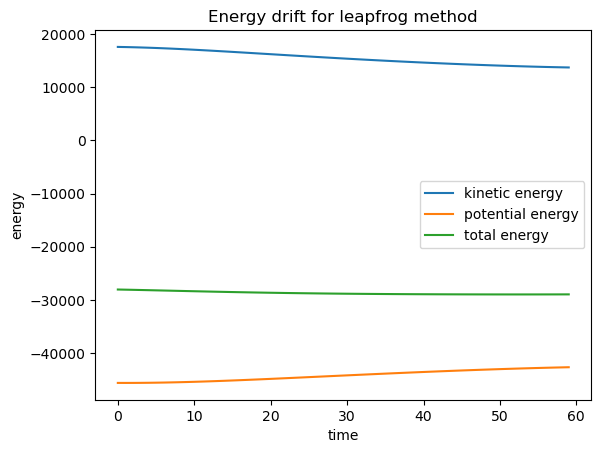

In [120]:
plt.plot(KE_hist, label="kinetic energy")
plt.plot(PE_hist, label="potential energy")
plt.plot(KE_hist + PE_hist, label="total energy")
plt.xlabel("time")
plt.ylabel("energy")
plt.title("Energy drift for leapfrog method")
plt.legend();